# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

['_imagenet_resnet50_top5inds_io_shape_dict', '_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet', 'resnet50_w1a2_imagenet']


In [2]:
#mobilenetv1_w4a4 is available on U250 and ZCU104
#accel = models.mobilenetv1_w4a4_imagenet()
#resnet50_w1a2 is available on U250 only
accel = models.resnet50_w1a2_imagenet()
#some systems with custom builds might require a manual platform setting:
#accel = models.mobilenetv1_w4a4_imagenet("ZCU102")

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 224, 224, 3) DataType.UINT8
Expected output shape and datatype: (1, 5) DataType.UINT16


# Prepare loading of ImageNet validation dataset

In [4]:
import numpy as np
from PIL import Image
from dataset_loading import FileQueue, ImgQueue
import os

# 2 ways to provide the data:
# without a label file: expect images in 1000 sorted subfolders
# with a label file: expect images directly in val directory
val_dir = os.environ["IMAGENET_VAL_PATH"]
label_file = None
print(val_dir)

/proj/xlabs_t3/users/ml-workspace/datasets/imagenet/raw-images/imagenet_symlink/val


In [5]:
def img_resize(img, size):
    w, h = img.size
    if (w <= h and w == size) or (h <= w and h == size):
        return img
    if w < h:
        ow = size
        oh = int(size * h / w)
        return img.resize((ow, oh), Image.BILINEAR)
    else:
        oh = size
        ow = int(size * w / h)
        return img.resize((ow, oh), Image.BILINEAR)

def img_center_crop(img, size):
    crop_height, crop_width = (size, size)
    image_width, image_height = img.size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))

def pre_process(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    img = img_resize(img, 256)
    img = img_center_crop(img, 224)
    img = np.array(img, dtype=np.uint8)
    return img

def setup_dataloader(val_path, label_file_path = None, batch_size=100, n_images = 50000):
    if label_file_path is None:
        val_folders = [ f.name for f in os.scandir(val_path) if f.is_dir() ]
        assert len(val_folders) == 1000, "Expected 1000 subfolders in ILSVRC2012 val"
        files = []
        labels = []
        for idx, folder in enumerate(val_folders):
            current_files = sorted(os.listdir(os.path.join(val_path, folder)))
            current_files = [os.path.join(folder, file) for file in current_files]
            files.extend(current_files)
            labels.extend([idx]*len(current_files))
        files = files[:n_images]
    else:
        files = ['ILSVRC2012_val_{:08d}.JPEG'.format(i) for i in range(1,n_images+1)]
        labels = np.loadtxt(label_file_path, dtype=int, usecols=1)

    file_queue = FileQueue()
    file_queue.load_epochs(list(zip(files,labels)), shuffle=False)
    img_queue = ImgQueue(maxsize=batch_size)
    img_queue.start_loaders(file_queue, num_threads=4, img_dir=val_path, transform=pre_process)
    return img_queue

# Classify a single image

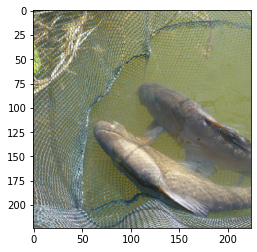

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

img_queue = setup_dataloader(val_dir, label_file, 1, 1)

test_single_x, test_single_y = img_queue.get()

plt.imshow(test_single_x)
plt.show()

In [7]:
test_single_y

0

In [8]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [9]:
accel_out = accel.execute(accel_in)

In [10]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[  0. 390. 391.  48. 394.]]


In [11]:
%%timeit
accel_out = accel.execute(accel_in)

2 ms ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Validate accuracy on entire ImageNet validation set

In [12]:
batch_size = 100
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Accelerator buffer shapes are (100, 224, 224, 3) for input, (100, 5, 2) for output


In [13]:
img_queue = setup_dataloader(val_dir, label_file, batch_size)

ok = 0
nok = 0
i = 0
while not img_queue.last_batch:
    imgs, lbls = img_queue.get_batch(batch_size, timeout=None)
    imgs = np.array(imgs)
    exp = np.array(lbls)
    
    ibuf_normal = imgs.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 1 : total OK 90 NOK 10
batch 2 : total OK 163 NOK 37
batch 3 : total OK 239 NOK 61
batch 4 : total OK 304 NOK 96
batch 5 : total OK 393 NOK 107
batch 6 : total OK 484 NOK 116
batch 7 : total OK 575 NOK 125
batch 8 : total OK 663 NOK 137
batch 9 : total OK 749 NOK 151
batch 10 : total OK 838 NOK 162
batch 11 : total OK 917 NOK 183
batch 12 : total OK 1006 NOK 194
batch 13 : total OK 1099 NOK 201
batch 14 : total OK 1168 NOK 232
batch 15 : total OK 1253 NOK 247
batch 16 : total OK 1333 NOK 267
batch 17 : total OK 1385 NOK 315
batch 18 : total OK 1437 NOK 363
batch 19 : total OK 1507 NOK 393
batch 20 : total OK 1581 NOK 419
batch 21 : total OK 1637 NOK 463
batch 22 : total OK 1716 NOK 484
batch 23 : total OK 1782 NOK 518
batch 24 : total OK 1841 NOK 559
batch 25 : total OK 1917 NOK 583
batch 26 : total OK 1999 NOK 601
batch 27 : total OK 2075 NOK 625
batch 28 : total OK 2126 NOK 674
batch 29 : total OK 2211 NOK 689
batch 30 : total OK 2273 NOK 727
batch 31 : total OK 2325 NOK 775
ba

batch 237 : total OK 17157 NOK 6543
batch 238 : total OK 17239 NOK 6561
batch 239 : total OK 17312 NOK 6588
batch 240 : total OK 17352 NOK 6648
batch 241 : total OK 17408 NOK 6692
batch 242 : total OK 17463 NOK 6737
batch 243 : total OK 17519 NOK 6781
batch 244 : total OK 17595 NOK 6805
batch 245 : total OK 17635 NOK 6865
batch 246 : total OK 17714 NOK 6886
batch 247 : total OK 17756 NOK 6944
batch 248 : total OK 17816 NOK 6984
batch 249 : total OK 17889 NOK 7011
batch 250 : total OK 17931 NOK 7069
batch 251 : total OK 17989 NOK 7111
batch 252 : total OK 18041 NOK 7159
batch 253 : total OK 18089 NOK 7211
batch 254 : total OK 18152 NOK 7248
batch 255 : total OK 18215 NOK 7285
batch 256 : total OK 18287 NOK 7313
batch 257 : total OK 18350 NOK 7350
batch 258 : total OK 18410 NOK 7390
batch 259 : total OK 18459 NOK 7441
batch 260 : total OK 18533 NOK 7467
batch 261 : total OK 18602 NOK 7498
batch 262 : total OK 18662 NOK 7538
batch 263 : total OK 18720 NOK 7580
batch 264 : total OK 18775 N

batch 461 : total OK 31208 NOK 14892
batch 462 : total OK 31272 NOK 14928
batch 463 : total OK 31342 NOK 14958
batch 464 : total OK 31423 NOK 14977
batch 465 : total OK 31480 NOK 15020
batch 466 : total OK 31538 NOK 15062
batch 467 : total OK 31609 NOK 15091
batch 468 : total OK 31679 NOK 15121
batch 469 : total OK 31765 NOK 15135
batch 470 : total OK 31839 NOK 15161
batch 471 : total OK 31916 NOK 15184
batch 472 : total OK 31978 NOK 15222
batch 473 : total OK 32058 NOK 15242
batch 474 : total OK 32118 NOK 15282
batch 475 : total OK 32189 NOK 15311
batch 476 : total OK 32265 NOK 15335
batch 477 : total OK 32346 NOK 15354
batch 478 : total OK 32433 NOK 15367
batch 479 : total OK 32516 NOK 15384
batch 480 : total OK 32595 NOK 15405
batch 481 : total OK 32634 NOK 15466
batch 482 : total OK 32696 NOK 15504
batch 483 : total OK 32766 NOK 15534
batch 484 : total OK 32824 NOK 15576
batch 485 : total OK 32865 NOK 15635
batch 486 : total OK 32929 NOK 15671
batch 487 : total OK 32993 NOK 15707
b

In [15]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

Final top-1 accuracy: 67.898%


## More benchmarking

In [16]:
accel.throughput_test()

{'runtime[ms]': 33.641815185546875,
 'throughput[images/s]': 2972.491212155573,
 'DRAM_in_bandwidth[Mb/s]': 447.4431571833541,
 'DRAM_out_bandwidth[Mb/s]': 0.029724912121555733,
 'DRAM_extw_idma0_bandwidth[Mb/s]': 6087.662002494613,
 'fclk[mhz]': 178,
 'batch_size': 100,
 'fold_input[ms]': 0.03409385681152344,
 'pack_input[ms]': 0.03838539123535156,
 'copy_input_data_to_device[ms]': 8.066892623901367,
 'copy_output_data_from_device[ms]': 0.04982948303222656,
 'unpack_output[ms]': 8.891582489013672,
 'unfold_output[ms]': 0.0054836273193359375}